In [2]:
from platform import python_version
print(python_version())

3.6.10


In [3]:
import numpy as np
import matplotlib.pyplot as plt

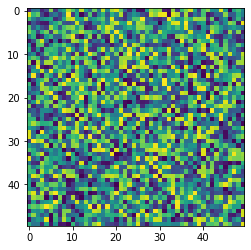

In [43]:
#checking dependencies

arr= np.random.randint(255, size=(50,50))
plt.imshow(arr)

# SRGAN Implementation on random dataset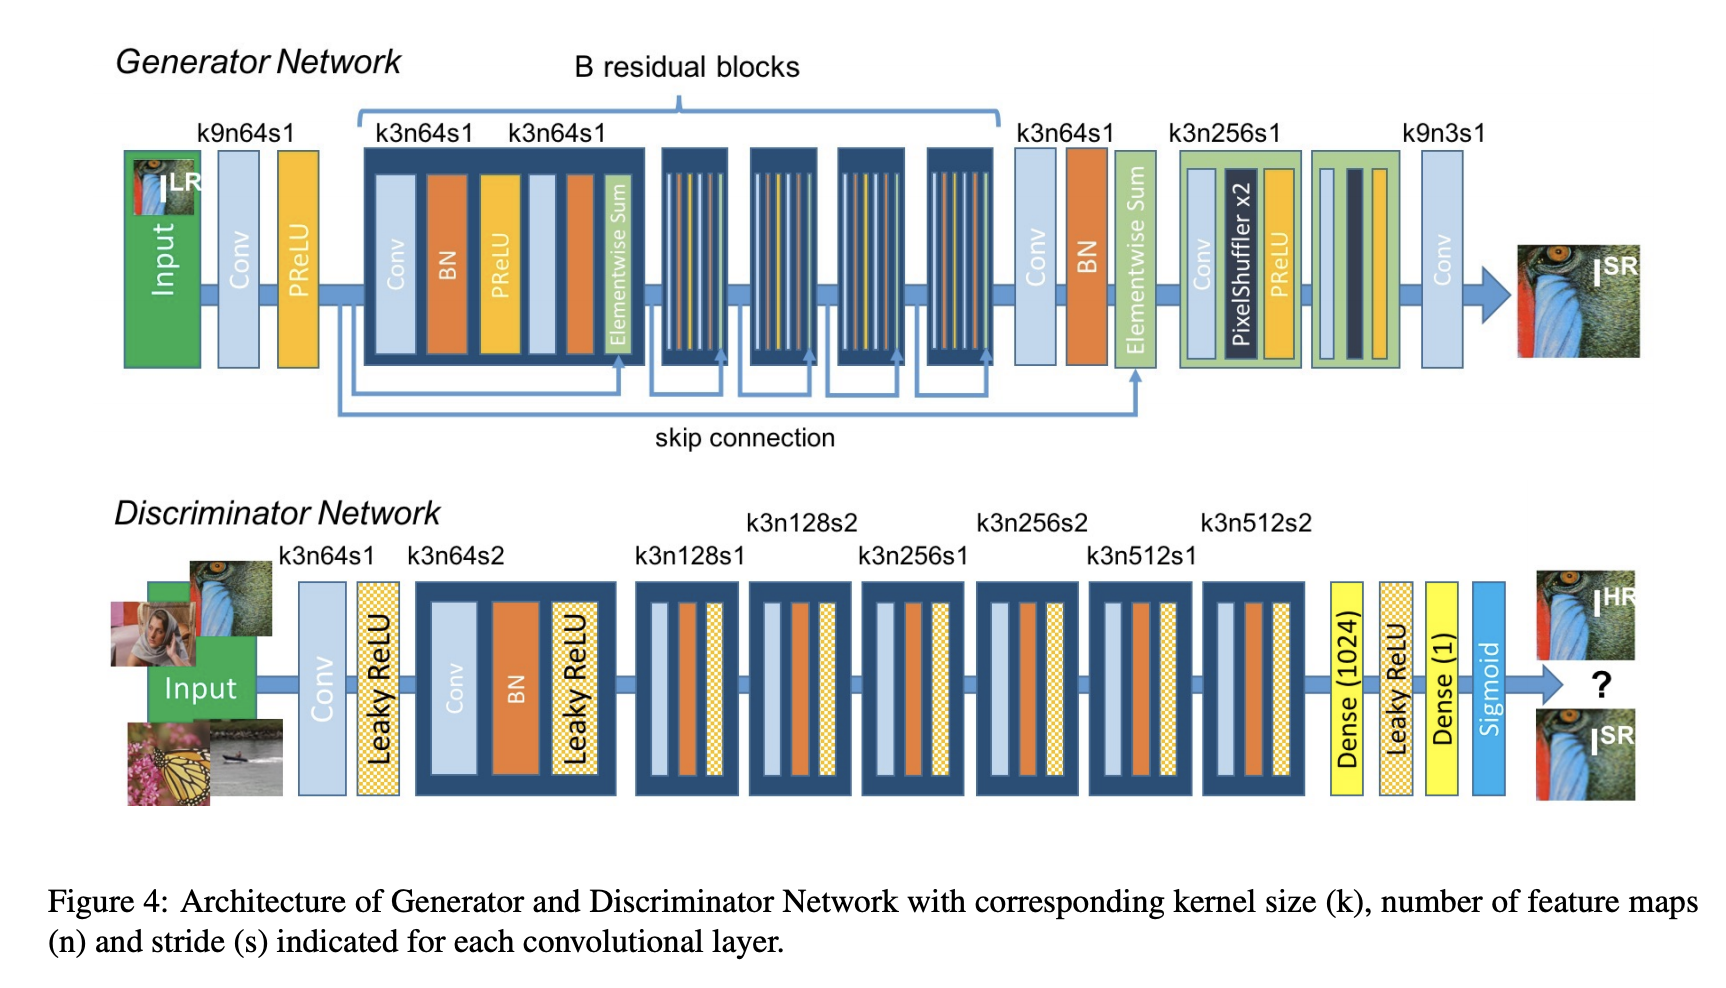

## Importing depencies

In [44]:
!pip install tensorflow

In [45]:
import os
import cv2
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg19 import VGG19
print("tensorflow version: ",tf.__version__)

tensorflow version:  2.6.2


# Generator network

In [46]:
input_shape=(64,64,3)

In [47]:
def buildc2dlayer(l1,filters,kernel_size, strides, act):
    
    x= tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides,  padding='same')(l1)
    
    if act=='yes':
        #print("activation applied")
        x= tf.keras.layers.Activation('relu')(x)
        
        return x
    else:
        #print("activation not applied")
        
        return x

In [48]:
def buildupsamplelayer(l1,upsample_size,filters,kernel_size, strides, act):
    
    y= tf.keras.layers.UpSampling2D(size=upsample_size)(l1)
    y= tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides,  padding='same')(y)
    
    if act=='yes':
        #print("activation applied")
       
        y= tf.keras.layers.Activation('relu')(y)
        
        return y
    else:
        
        #print("activation not applied")
        
        return y

In [49]:
def residualBlock(inpLayer):
    
    kernel_size=3
    no_of_filters=64
    stride=1
    
    #1st conv2d layer for residual model
    
    layer1= tf.keras.layers.Conv2D(filters= no_of_filters,kernel_size=kernel_size,
                                   strides= stride, padding='same')(inpLayer)
    layer1= tf.keras.layers.Activation(activation="relu")(layer1)
    layer1= tf.keras.layers.BatchNormalization(momentum=0.8)(layer1)
    
    #2nd conv2d layer with same parameters
    
    layer2= tf.keras.layers.Conv2D(filters= no_of_filters,kernel_size=kernel_size,
                                   strides= stride, padding='same')(layer1)
    layer2= tf.keras.layers.Activation(activation="relu")(layer2)
    layer2= tf.keras.layers.BatchNormalization(momentum=0.8)(layer2)
    
    #adding inpLayer and layer2
    
    opLayer=tf.keras.layers.Add()([layer2,inpLayer])
    
    return opLayer

In [50]:
def generatorModel():
    
    #preresidual blocks

    inputLayer= tf.keras.layers.Input(input_shape)   

    g1= buildc2dlayer(inputLayer,64,9,1,'yes')   
    
    #multiple residual blocks

    residual= residualBlock(g1)                                                #3
    for i in range(5):
        residual= residualBlock(residual)
    
    #postresidual blocks
                                                
    g2= buildc2dlayer(residual,64,3,1,'no')
    
    g2= tf.keras.layers.BatchNormalization(momentum=0.8)(g2)
    
    #adding g1 and g2
                                                                
    g3=tf.keras.layers.Add()([g2,g1])
    
    #post residual upsample blocks                          

    g4= buildupsamplelayer(g3,2,256,3,1,'yes')
    g5= buildupsamplelayer(g4,2,256,3,1,'yes')
    
    #final generator layer

    g6= buildc2dlayer(g5,3,9,1,'no')
    genOutput= tf.keras.layers.Activation('tanh')(g6)
    
    model= tf.keras.Model(inputs=[inputLayer], outputs=[genOutput], name='generatorModel')
    
    return model

# Discriminator network

In [51]:
disc_input_shape=(256, 256,3)

In [52]:
def buildc2dlayerfordisc(inputLayer,filters,kernel_size, strides):
    
    x= tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides,  padding='same')(inputLayer)
    x= tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x= tf.keras.layers.BatchNormalization(momentum=0.8)(x)
    return x

In [53]:
#input layer

def discriminatorModel():

    input_layer= tf.keras.layers.Input(disc_input_shape)

    d1= tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
    d1= tf.keras.layers.LeakyReLU(alpha=0.2)(d1)

    d2= buildc2dlayerfordisc(d1,64,3,2)

    d3= buildc2dlayerfordisc(d2,128,3,1)

    d4= buildc2dlayerfordisc(d3,128,3,2)

    d5= buildc2dlayerfordisc(d4,256,3,1)

    d6= buildc2dlayerfordisc(d5,256,3,2)

    d7= buildc2dlayerfordisc(d6,512,3,1)

    d8= buildc2dlayerfordisc(d7,512,3,2)

    d9= tf.keras.layers.Dense(units= 1024)(d8)

    d9= tf.keras.layers.LeakyReLU(alpha=0.2)(d9)

    discOutput= tf.keras.layers.Dense(units=1, activation= 'sigmoid')(d9)  #output probability of sr image given as input

    model= tf.keras.Model(inputs= [input_layer], outputs=[discOutput], name='discriminator')
    
    return model

# Training the model 

### Loading VGG19 pretrained weights to calculate VGG loss for the model:

In [54]:
def vgg_featureExtraction():
    
    model=VGG19(weights='imagenet', include_top=False, input_shape=(256,256,3))
    
    for layer in model.layers:
        layer.trainable=False
        
    feature_extractor=tf.keras.Sequential()
    
    for layer in model.layers[:10]:
        feature_extractor.add(layer)
        
    return feature_extractor

# Adversarial Network  

### Combining the Generator, Discriminator and the VGG network together:

In [55]:
def adversarialModel(generator, discriminator, vgg):
    
    lowRes_input= tf.keras.Input(shape=(64,64,3))
    highRes_input= tf.keras.Input(shape=(256,256,3))
    
    #generating hr image from the generator

    hr_image=generator(lowRes_input)
    
    #extracting features of generated hr image using VGG19 network

    HRimage_features= vgg(hr_image)
    
    #feeding the hr image to the discriminator
    
    discriminator.trainable = False
    
    disc_output=discriminator(hr_image)
    
    model= tf.keras.Model(inputs=[lowRes_input,highRes_input],outputs=[disc_output,HRimage_features])
    
    print(model.summary())
    
    return model


# Compiling and Training the networks

In [56]:
#hyperparameters
epochs=10000
batch_size=1

low_res_shape=(64,64,3)
high_res_shape=(256,256,3)

optimizer= tf.keras.optimizers.Adam(0.0002,0.5)

In [57]:
vgg= vgg_featureExtraction()
vgg.trainable= False
vgg.compile(loss='mse',optimizer=optimizer, metrics=['accuracy'])

In [58]:
generator=generatorModel()
discriminator=discriminatorModel()

discriminator.compile(loss='mse',optimizer=optimizer, metrics=['accuracy'])

In [59]:
adversarial_model=adversarialModel(generator,discriminator,vgg)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
generatorModel (Functional)     (None, 256, 256, 3)  1299011     input_4[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
discriminator (Functional)      (None, 16, 16, 1)    5219137     generatorModel[0][0]             
______________________________________________________________________________________________

In [60]:
adversarial_model.compile(loss=['binary_crossentropy','mse'],loss_weights=[1e-3,1],optimizer=optimizer)

In [61]:
#adding tensorboard to visualize results

tensorboard=tf.keras.callbacks.TensorBoard(log_dir="logs".format(time.time()))
tensorboard.set_model(generator)
tensorboard.set_model(discriminator)

/home/antpc/anaconda3/envs/ocr/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Working with dataset

In [1]:
import os
nir_images = []
path='nirscene1'
for filename in os.listdir(path):#itterating the filename inside the directory
    for imagename in os.listdir(path+'/'+filename):
        if 'nir' in imagename:
            print(imagename)
            nirimg = cv2.imread(os.path.join(path,filename,images))
            nir_images.append(nirimg)
        else:
            continue

0051_nir.tiff


NameError: name 'cv2' is not defined

In [93]:
len(images)

13

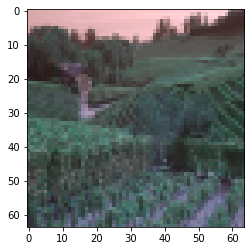

In [96]:
low_res_image=cv2.resize(nir_images[8], (64,64),interpolation = cv2.INTER_AREA)
high_res_image=cv2.resize(nir_images[8],(256,256), interpolation = cv2.INTER_CUBIC)
plt.imshow(low_res_image)
plt.show()

In [86]:
def sample_images(images):
    
    print("1")
    
    high_res_images=[]
    low_res_images=[]
    
    print("2")
    
    for image in images:
        
        low_res_image=cv2.resize(image, (64,64),interpolation = cv2.INTER_AREA)
        high_res_image=cv2.resize(image,(256,256), interpolation = cv2.INTER_CUBIC)
        
        
        high_res_images.append(high_res_image)
        low_res_images.append(low_res_image)
        
    return np.array(high_res_images),np.array(low_res_images)


In [87]:
high_res,low_res=sample_images(nir_images)

1
2


error: OpenCV(4.5.4) /tmp/pip-req-build-w88qv8vs/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [82]:
len(nir_images)

477

In [32]:
len(low_res)

12

In [39]:
tf.image.resize_with_pad(np.expand_dims(low_res[0],axis=0),64,64)

(64, 64, 3)


(12, 64, 64, 3)
(12, 256, 256, 3)


Text(0.5, 1.0, 'High resolution image by INTER_CUBIC interpolation.')

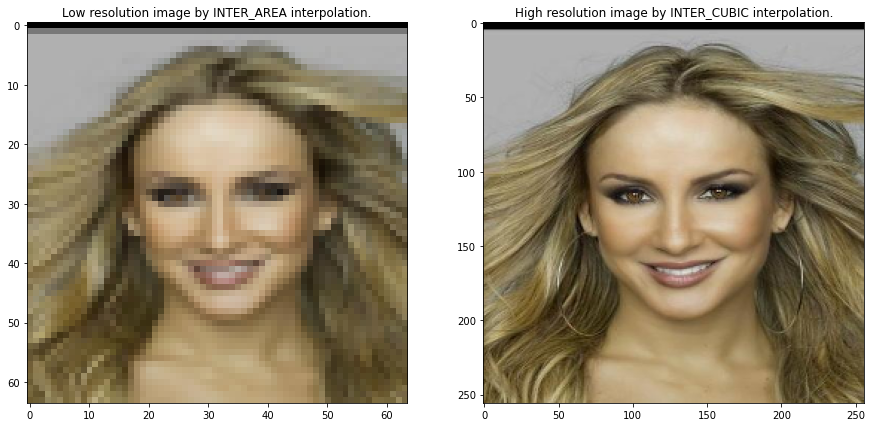

In [33]:
fig = plt.figure(figsize=(15,10))

rows = 1
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(tf.cast(np.squeeze(low_res[0]), dtype=tf.int32))
print(low_res.shape)
plt.title ("Low resolution image by INTER_AREA interpolation.")

fig.add_subplot(rows, columns, 2)
plt.imshow(tf.cast(np.squeeze(high_res[0]), dtype=tf.int32))
print(high_res.shape)
plt.title("High resolution image by INTER_CUBIC interpolation.")

# Training the discriminator network

In [37]:
for epoch in range(epochs):

    print(f"Epoch: {epoch+1}")

    high_res_batch,low_res_batch=sample_images(images,batch_size=12)


    real_labels=np.ones((1,16,16,1))   #to minimize the disc loss
    fake_labels=np.zeros((1,16,16,1))

    high_res_batch=high_res_batch/127.5-1
    low_res_batch=low_res_batch/127.5-1

    gen_loss_list=[]
    disc_loss_list=[]

    for i in range(len(high_res_batch)):
        
        lri=tf.image.resize_with_pad(np.expand_dims(low_res[0],axis=0),64,64)
        hri=tf.image.resize_with_pad(np.expand_dims(low_res[0],axis=0),256,256)
        

        generated_high_res_image=generator.predict_on_batch(lri)

        discriminator.trainable = True

        disc_real_loss= discriminator.train_on_batch(hri,real_labels)  #calculating distance b/w real high res image and array of ones
        disc_fake_loss= discriminator.train_on_batch(generated_high_res_image,fake_labels)

        disc_loss=0.5*np.add(disc_real_loss,disc_fake_loss)

        #high res image features

        image_features=vgg.predict(hri)

        #training the generator

        gen_loss=adversarial_model.train_on_batch([lri,hri],[real_labels,image_features])

        gen_loss_list.append(gen_loss)
        disc_loss_list.append(disc_loss)

    gen_loss = np.sum(gen_loss_list, axis=0) / len(gen_loss_list)
    disc_loss = np.sum(disc_loss_list, axis=0) / len(disc_loss_list)
    print("epoch:",epoch+1 ,"g_loss:", gen_loss, "d_loss:", disc_loss)   



NameError: name 'epochs' is not defined